In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# !pip install fastai==1.0.61

In [3]:
# !pip install timm

In [4]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from PIL import Image
import os
from glob import glob
import cv2
from tqdm import tqdm
import multiprocessing as mp
import pandas as pd
from matplotlib import pyplot as plt
from torchvision import transforms
import timm

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F

In [5]:
from utils import interleave, de_interleave, show_batch, AverageMeter
from learner import FixMatch
from dataset import FERDataset, get_transform

In [6]:
config = {}

config['data_path'] = 'D:\\data\\fer2013.csv'

config['size'] = 48
config['num_classes'] = 7
config['batch_size'] = 16
config['num_workers'] = 0
config['output_nodes'] = 1
config['epochs'] = 1
config['lr'] = 1e-3
config['mu'] = 7

config['lr'] = 1e-3
config['lr_step_size'] = 10
config['lr_gamma'] = 0.8

config['momentum'] = 0.9
config['weight_decay'] = 0.05
config['eval_step'] = 16
config['threshold'] = 0.95
config['T'] = 1.0
config['lambda_u'] = 0.9
config['freq_eval'] = 1
config['sch_name'] = 'step'
config['use_ema'] = True
config['ema_decay'] = 0.999

In [7]:
df_data = pd.read_csv(config['data_path'])
df_data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [8]:
df_data['Usage'].value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

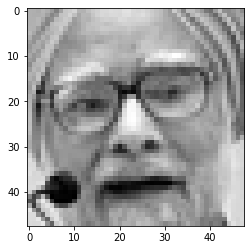

In [9]:
plt.imshow(np.reshape(np.array(df_data['pixels'].iloc[1].split(' '), dtype=np.uint8), (48,48)), cmap='gray')

In [10]:
df_train = df_data[df_data['Usage']=='Training']
## break down into labeled and unlabeled set
df_labeled, df_unlabeled = train_test_split(df_train, test_size = 0.98, random_state = 0)
df_labeled = df_labeled.reset_index();
df_unlabeled = df_unlabeled.reset_index();

In [11]:
# df_train['emotion'].value_counts()

In [12]:
# df_train

In [13]:
train_labeled_ds = FERDataset(df = df_labeled, transform = get_transform(config, is_train=True))
train_unlabeled_ds = FERDataset(df = df_unlabeled, transform = get_transform(config, is_train=True, is_labeled=False))

valid_ds = FERDataset(df = df_data[df_data['Usage']=='PublicTest'] , transform = get_transform(config))

In [14]:
train_labeled_dl = DataLoader(train_labeled_ds, 
                              sampler=RandomSampler(train_labeled_ds),
                              batch_size = config['batch_size'], 
                              num_workers = config['num_workers'])

train_unlabeled_dl = DataLoader(train_unlabeled_ds, 
                              sampler=RandomSampler(train_unlabeled_ds),
                              batch_size = config['batch_size']*config['mu'], 
                              num_workers = config['num_workers'])

valid_dl = DataLoader(valid_ds, 
                      sampler=SequentialSampler(valid_ds),
                      batch_size = config['batch_size'], 
                      num_workers = config['num_workers'])

In [15]:
for x, y in train_labeled_dl:
    print(x.shape)
    print(y)
    break

torch.Size([16, 3, 48, 48])
tensor([3, 0, 5, 5, 6, 2, 0, 6, 3, 2, 5, 3, 0, 6, 3, 0])


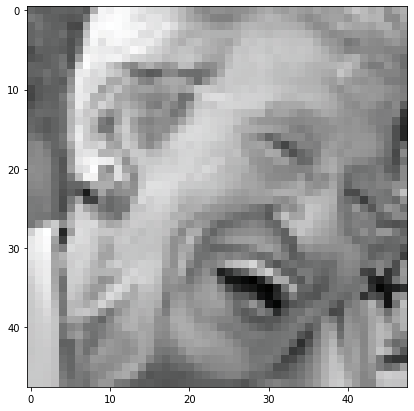

In [16]:
show_batch(x[0,:,:])

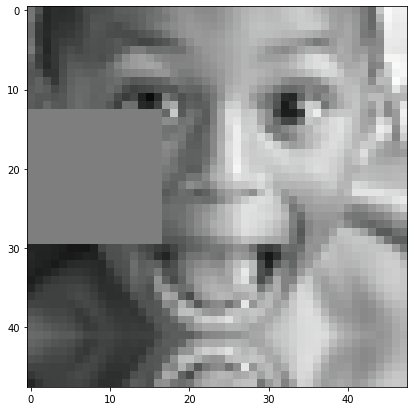

In [17]:
for x, y in train_unlabeled_dl:
    # print(x)
    # print(y)
    break
show_batch(x[1][100,:,:])

In [18]:
model = nn.Sequential(timm.create_model('resnet18',pretrained=True,num_classes = config['num_classes']))

In [19]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [20]:
classifier = FixMatch(model = model,
                      opt_func="Adam", 
                      device = device)

classifier.get_config(config)
classifier.get_dataloader((train_labeled_dl, train_unlabeled_dl), valid_dl)

In [21]:
classifier.fit()

100%|███████████████████████████████████████████████████| 16/16 [01:16<00:00,  4.77s/it, loss=2.17]


Training epoch: 1
	Train Loss: 2.167


100%|█████████████████████████████████████████████████| 225/225 [00:25<00:00,  8.70it/s, loss=2.26]

	Valid Loss: 2.262
	Metric: {'micro/precision': 0.12761214823070494, 'micro/recall': 0.12761214823070494, 'micro/f1': 0.12761214823070494, 'macro/precision': 0.14025970909911875, 'macro/recall': 0.14514593811233437, 'macro/f1': 0.09357330875642109}


In [22]:
classifier.save_checkpoint('./')

Saved checkpoint


In [26]:
classifier.lr_scheduler

In [27]:
classifier.load_checkpoint('./05_08_2022_19_21_56.pth')